In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


listed = drive.ListFile({'q': "title contains 'facial-keypoints-data.zip'"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = file['id']

fname = os.path.join('/content', 'facial-keypoints-data.zip')
print('downloading to {}'.format(fname))
f_ = drive.CreateFile({'id': file_id})
f_.GetContentFile(fname)

downloading to /content/facial-keypoints-data.zip


In [ ]:
!unzip facial-keypoints-data.zip

## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [ ]:
# from get_data import unpack
# unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [28]:
### Useful routines for preparing data
import pandas as pd
from numpy import array, zeros
from os.path import join
import os
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import numpy as np



def load_imgs_and_keypoints(dirname='facial-keypoints-data'):
    # Write your code for loading images and points here
    csv_path = join(dirname, "gt.csv")
    keypoints = pd.read_csv(csv_path, index_col=False)
    keypoints = keypoints.drop(columns=['filename'])
    keypoints = keypoints.values
    
    keypoints = np.array(keypoints, dtype = "float64")
    
    imgs_path = join(dirname, "images") ;
    extensions = [".jpg", ".jpeg", ".png"]
    file_list = [f for f in os.listdir(imgs_path) if os.path.splitext(f)[1] in extensions]
    file_list = sorted(file_list)
    
    imgs = []
    
    for count,f in enumerate(file_list):
        img = imread(join(imgs_path,f))
        shape_img = img.shape
        if len(shape_img) < 3:
            img = gray2rgb(img)
            
        rows, cols, _ = img.shape
        
        keypoints[count, 0::2] = (keypoints[count, 0::2]/cols) - 0.5
        keypoints[count, 1::2] = (keypoints[count, 1::2]/rows) - 0.5
        
        image_resized = resize(img, (100,100,3))
        imgs.append(image_resized)
    
    
    return [imgs, keypoints]

imgs, points = load_imgs_and_keypoints()

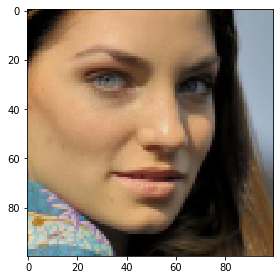

In [30]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
# points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

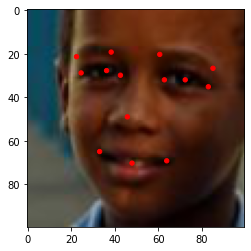

In [32]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    points = (points + 0.5) * 100
    x_s = points[0::2]
    y_s = points[1::2]
    
    fig,ax = plt.subplots(1)
    
    ax.imshow(img)
    
    for x,y in zip(x_s,y_s):
        cir = Circle((x,y),1, color = "red")
        ax.add_patch(cir)
    
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [33]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1, random_state=32)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

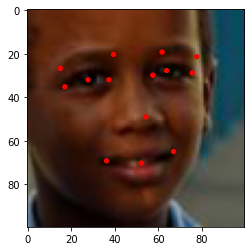

In [34]:
def flip_img(img, points):
    # Write your code for flipping here
    f_img = np.copy(img)
    f_img = np.fliplr(f_img)

    f_points = np.copy(points)
    f_points[0::2] = -1 * f_points[0::2]
    
    return [f_img, f_points]


f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

In [ ]:
def rotate_img(img, points, angle = ):
    # Write your code for flipping here
    f_img = np.copy(img)
    f_img = np.fliplr(f_img)

    f_points = np.copy(points)
    f_points[0::2] = -1 * f_points[0::2]
    
    return [f_img, f_points]

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [35]:
# Write your code here
def augment_data(imgs, points):
    
    aug_imgs_train = []
    aug_points_train = []
    for i in range(len(imgs)):
        img = imgs[i]
        points_img = points[i]
        aug_img, aug_points = flip_img(img, points_img)
        
        aug_imgs_train.append(img)
        aug_points_train.append(points_img)
        
        aug_imgs_train.append(aug_img)
        aug_points_train.append(aug_points)
    
    return [np.array(aug_imgs_train), np.array(aug_points_train)]
        
aug_imgs_train, aug_points_train = augment_data(imgs_train, points_train)    

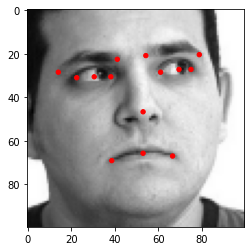

In [36]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

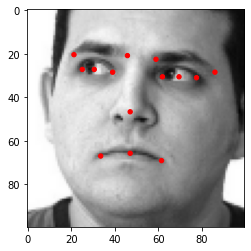

In [37]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

In [38]:
imgs_val = np.array(imgs_val)
points_val = np.array(points_val) 

In [39]:
aug_imgs_train.shape

(10800, 100, 100, 3)

In [40]:
imgs_val.shape

(600, 100, 100, 3)

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [104]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, MaxPooling2D, Flatten, Dense

model = models.Sequential()
initializer = tf.keras.initializers.GlorotUniform()

model.add(Conv2D(16, (3,3), input_shape=(100, 100, 3), activation='relu',kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3), activation='relu',kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu' ,kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))  

model.add(Conv2D(256, (3,3), activation='relu' ,kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,kernel_initializer=initializer, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(256,kernel_initializer=initializer, activation='relu'))
model.add(Dropout(0.2)) 

model.add(Dense(28))

In [105]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 8, 8, 256)       

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [106]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info

# from keras.callbacks import ModelCheckpoint
# from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

history = model.fit(aug_imgs_train, aug_points_train, 
                    epochs=100, 
                    batch_size=256,
                    shuffle=True,
                    validation_data=(imgs_val, points_val)) 

Epoch 1/100
43/43 [==============================] - 3s 39ms/step - loss: 0.0249 - accuracy: 0.0380 - val_loss: 0.0182 - val_accuracy: 0.0100
Epoch 2/100
43/43 [==============================] - 1s 35ms/step - loss: 0.0194 - accuracy: 0.0232 - val_loss: 0.0182 - val_accuracy: 0.0100
Epoch 3/100
43/43 [==============================] - 1s 34ms/step - loss: 0.0187 - accuracy: 0.0247 - val_loss: 0.0170 - val_accuracy: 0.0100
Epoch 4/100
43/43 [==============================] - 2s 36ms/step - loss: 0.0182 - accuracy: 0.0241 - val_loss: 0.0197 - val_accuracy: 0.0133
Epoch 5/100
43/43 [==============================] - 2s 35ms/step - loss: 0.0177 - accuracy: 0.0237 - val_loss: 0.0192 - val_accuracy: 0.0200
Epoch 6/100
43/43 [==============================] - 2s 35ms/step - loss: 0.0172 - accuracy: 0.0289 - val_loss: 0.0140 - val_accuracy: 0.0450
Epoch 7/100
43/43 [==============================] - 1s 34ms/step - loss: 0.0164 - accuracy: 0.0465 - val_loss: 0.0163 - val_accuracy: 0.0333
Epoch 

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [103]:
predictions_test = model.predict(imgs_val)

train data  0


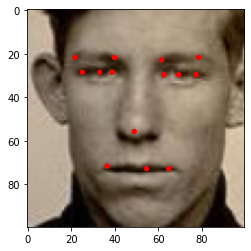

predicted data  0


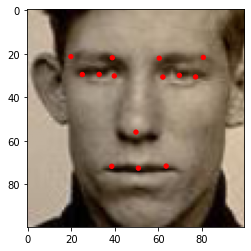

train data  1


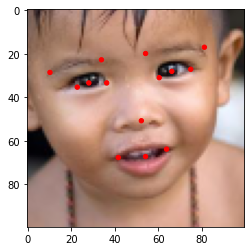

predicted data  1


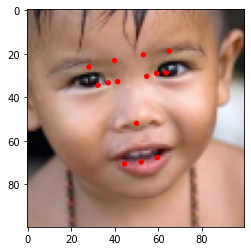

train data  2


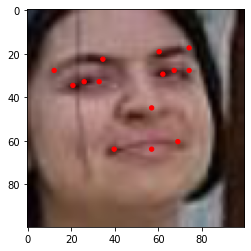

predicted data  2


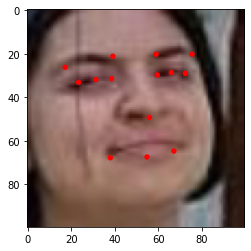

train data  3


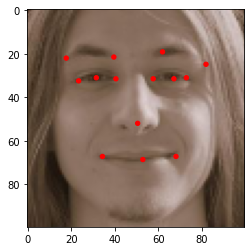

predicted data  3


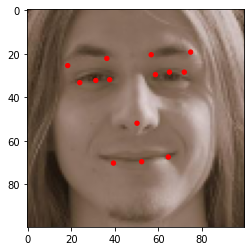

train data  4


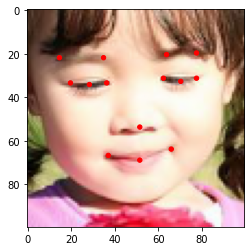

predicted data  4


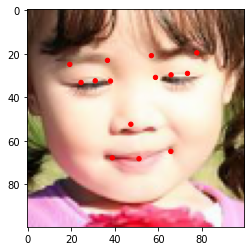

train data  5


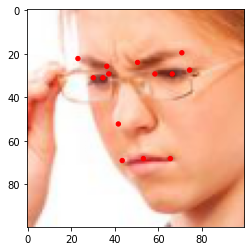

predicted data  5


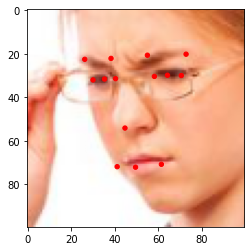

train data  6


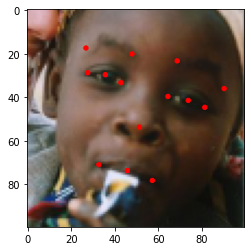

predicted data  6


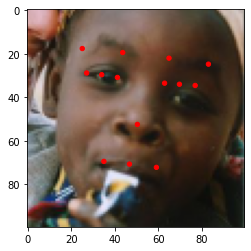

train data  7


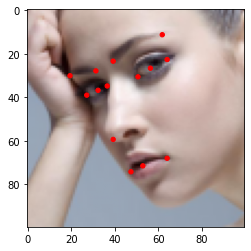

predicted data  7


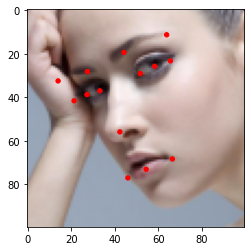

train data  8


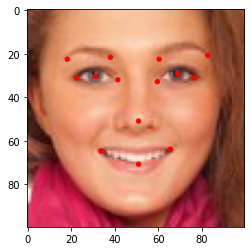

predicted data  8


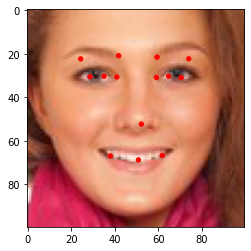

train data  9


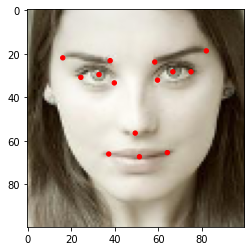

predicted data  9


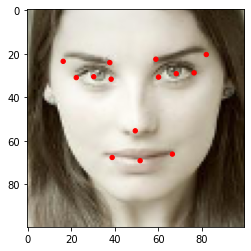

train data  10


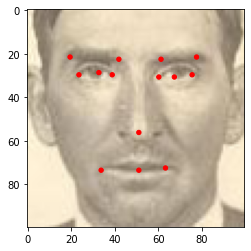

predicted data  10


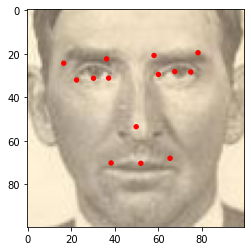

train data  11


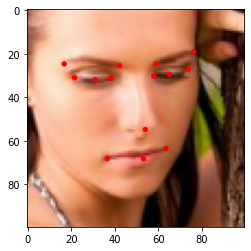

predicted data  11


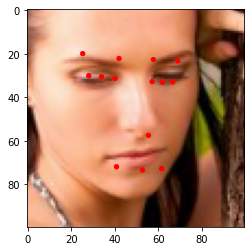

train data  12


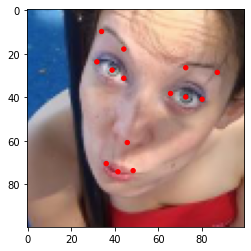

predicted data  12


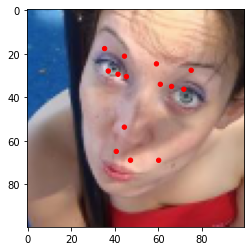

train data  13


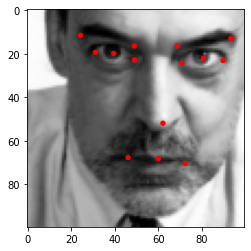

predicted data  13


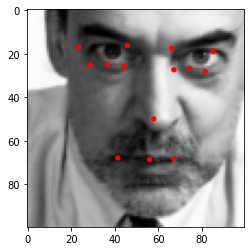

train data  14


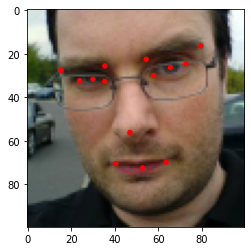

predicted data  14


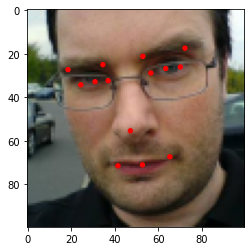

train data  15


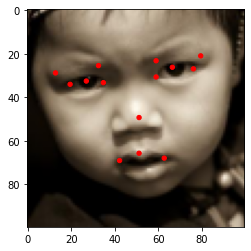

predicted data  15


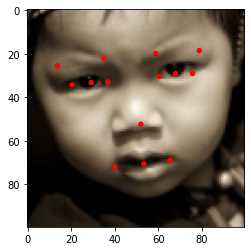

train data  16


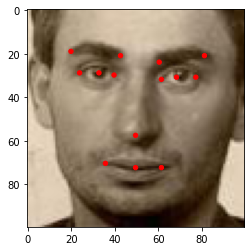

predicted data  16


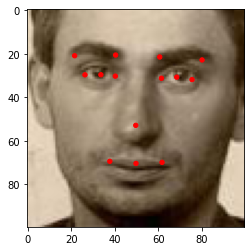

train data  17


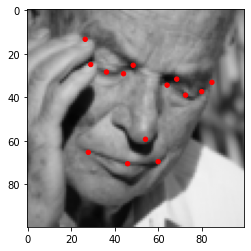

predicted data  17


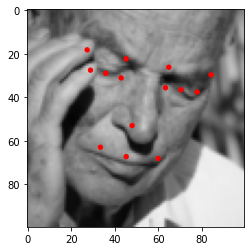

train data  18


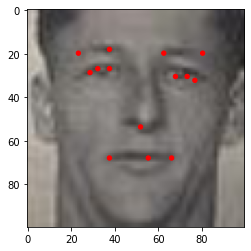

predicted data  18


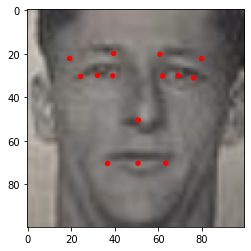

train data  19


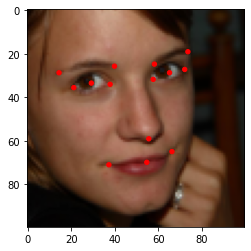

predicted data  19


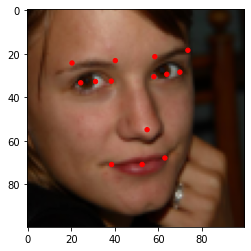

In [146]:
# Example of output
for a in range(0, 20):
  print("train data ", a)
  visualize_points(imgs_val[a], points_val[a])
  print("predicted data ", a)
  visualize_points(imgs_val[a], predictions_test[a])